In [339]:
import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm 
import math
import coremltools as ct
import pandas as pd
from shapely.geometry import Polygon
import sys

In [2]:
IMAGE_PATH = 'images'
XML_PATH = 'annotations'

images = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.png', os.listdir(IMAGE_PATH))))
xmls = list(sorted(filter(lambda x: os.path.splitext(x)[1] == '.xml', os.listdir(XML_PATH))))

images_train = images[:753]
xmls_train = xmls[:753]

images_test = images[753:]
xmls_test = xmls[753:]

In [59]:
def parse_annot(xml):
    bbox = []
    labels = []
    
    label_map = {
        'without_mask': 1,
        'with_mask': 2,
        'mask_weared_incorrect': 3 
    }
    
    tree = ET.parse(xml)
    root = tree.getroot()
    
    for box in root.iter('object'):
        bbox.append(
               [
                   int(box.find('bndbox/xmin').text),
                   int(box.find('bndbox/ymin').text),
                   int(box.find('bndbox/xmax').text),
                   int(box.find('bndbox/ymax').text),
               ]
        )
        labels.append(
            label_map[box.find('name').text]
        )
    
    return bbox, labels

def draw_boxes(img, bbox, labels):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    color_label = {
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255)
    }
    
    for (x, y, w, h), label in zip(bbox, labels):
        x, y, w, h = [int(n) for n in [x, y, w, h]]
        cv2.rectangle(img, (x,y), (w,h), color_label[label], 1)
        
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [7]:
def rcnn_predict_img(img, nm_thrs=0.3, score_thrs=0.8):
    img = transforms.ToTensor()(img)
    img = img.to("cuda")
    model.eval()
    
    with torch.no_grad():
        predictions = model(img.unsqueeze(0))
        
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(), predictions[0]['scores'].cpu(), nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_boxes, test_labels

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load('./masknet_10_epochs.pth', map_location=device)
model.load_state_dict(checkpoint)
if torch.cuda.is_available():
    model.cuda()

## 1. evaluation - correct number of detected faces

In [394]:
class Detection():
    def __init__(self, boxes, labels, image):
        self.boxes = boxes
        self.labels = labels
        self.image = image
def printDetection(detection):
    name = ""
    if detection.image is None:
        name = "Ground truth"
    else:
        name = "Prediction"
    print(name)
    print("Boxes")
    for b in detection.boxes:
        for bb in b:
            print(bb, end=" ")
        print()
    print("Labels")
    for l in detection.labels:
        print(l, end=" ")
    print("------------------------")

In [395]:
# create detections
n = len(images_test)
detections = []
for i in range(n):
    detection = {}
    boxes, labels = parse_annot(os.path.join(XML_PATH, xmls_test[i]))
    detection["annotation"] = Detection(boxes, labels, None)
    
    img = cv2.imread(os.path.join(IMAGE_PATH, images_test[i]))
    boxes, labels = rcnn_predict_img(img)
    detection["prediction"] = Detection(boxes, labels, img)
    detections.append(detection)

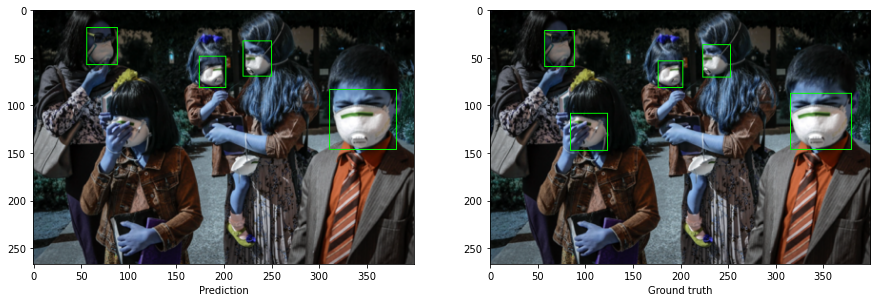

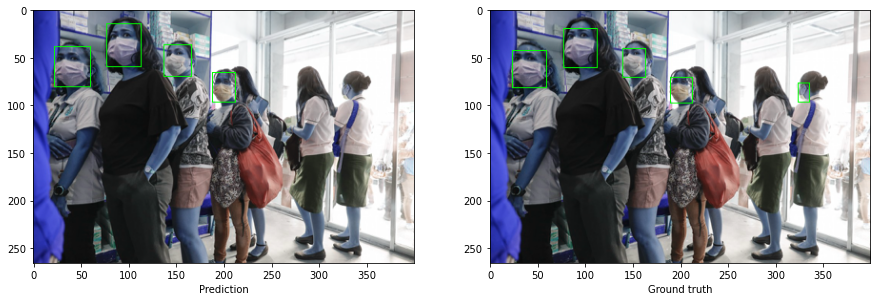

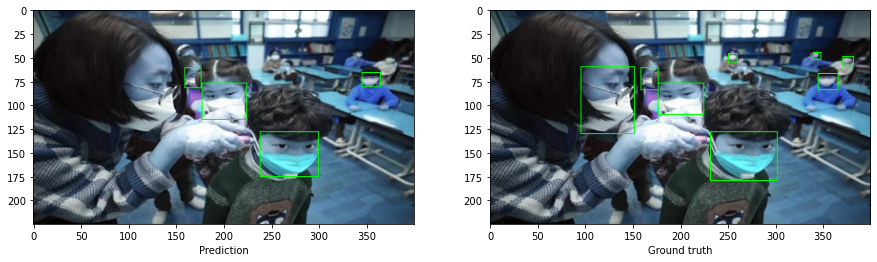

Number of faces in annotations matches the prediction: 67/100


In [396]:
# compare number of detected faces
correct = 0
n_show = 0
correct_detections = []
for detection in detections:
    if len(detection["annotation"].boxes) == len(detection["prediction"].boxes):
        correct += 1
        correct_detections.append(detection)
    else:
        if n_show < 3:
            drawEvaluation(detection["prediction"].image, detection["annotation"].boxes, detection["annotation"].labels,
                           detection["prediction"].boxes, detection["prediction"].labels)
            n_show+=1
print("Number of faces in annotations matches the prediction: " + str(correct) + "/" + str(len(images_test)))

In [397]:
def drawEvaluation(img, gboxes, glabels, pboxes, plabels):
    img1 = draw_boxes(img, pboxes, plabels)
    img2 = draw_boxes(img, gboxes, glabels)
    # Display the result
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.imshow(img1)
    ax1.set_xlabel('Prediction')
    ax2.imshow(img2)
    ax2.set_xlabel('Ground truth')
    plt.show()

## 2. Evaluation - Box coordinates - Jacaard similarity

In [414]:
sortedDetections = sortDetections(correct_detections)

In [415]:
from copy import copy
def sortDetections(detections):
    sortedDetections = []
    for detection in detections:
        det = {}
        indices = []
        for prediction_box in detection["prediction"].boxes: # go through every predicted object
            index = getAnnotationIndex(prediction_box, detection["annotation"].boxes)
            indices.append(index)
        sortedBoxes = sortByIndices(indices, detection["prediction"].boxes)
        sortedLabels = sortByIndices(indices, detection["prediction"].labels)
        det["annotation"] = detection["annotation"]
        det["prediction"] = Detection(sortedBoxes, sortedLabels, detection["prediction"].image)
        sortedDetections.append(det)
    return sortedDetections
        
def getAnnotationIndex(prediction_box, annotation_boxes):
    max_overlap = -1
    max_overlap_index = -1
    for i in range(len(annotation_boxes)):
        overlap = calculate_iou(transformBox(prediction_box), transformBox(annotation_boxes[i]))
        if overlap > max_overlap:
            max_overlap = overlap
            max_overlap_index = i
    return max_overlap_index

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

def sortByIndices(indices, boxes):
    newBoxes = [b for b in boxes]
    for index, value in enumerate(indices):
        newBoxes[value] = boxes[index]
    return newBoxes
    
def transformBox(box):
    x1 = box[0]
    y1 = box[1]
    
    x2 = box[2]
    y2 = box[3]
    
    return [[x1, y1], [x2, y1], [x2,y2], [x1,y2]]

In [441]:
overall_boxes = 0
overlap = 0
for detection in sortedDetections:
    n_boxes = len(detection["prediction"].boxes)
    for i in range(n_boxes):
        prediction_box = transformBox(detection["prediction"].boxes[i])
        annotation_box = transformBox(detection["annotation"].boxes[i])
        overlap += calculate_iou(prediction_box, annotation_box)
    overall_boxes += n_boxes
print("Overlap: " + str(overlap / overall_boxes))

Overlap: 0.7991639535782


In [449]:
overall_boxes

219

In [450]:
overlap

175.0169058336258

## 3. Evaluation - labels

In [446]:
correct = 0
overall_labels = 0
incorrect_detections = []
for detection in sortedDetections:
    n_labels = len(detection["prediction"].labels)
    for i in range(n_labels):
        prediction_label = detection["prediction"].labels[i]
        annotation_label = detection["annotation"].labels[i]
        if prediction_label == annotation_label:
            correct += 1
        else:
            incorrect_detections.append(detection)
    overall_labels += n_labels
print("Overlap: " + str(correct) + "/" + str(overall_labels))

Overlap: 213/219


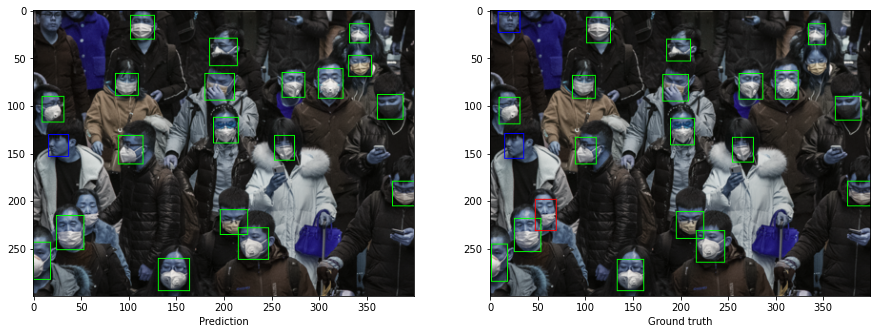

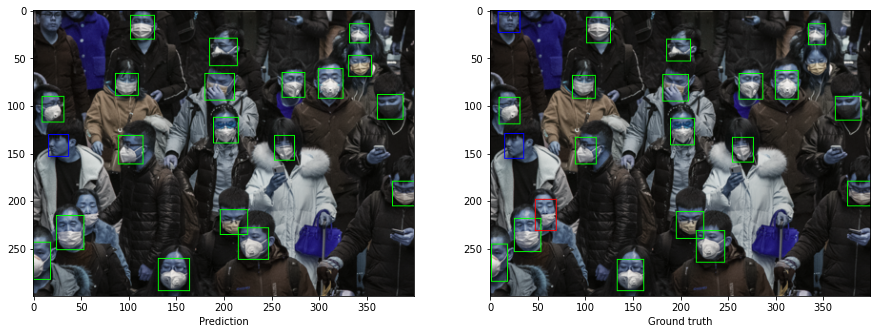

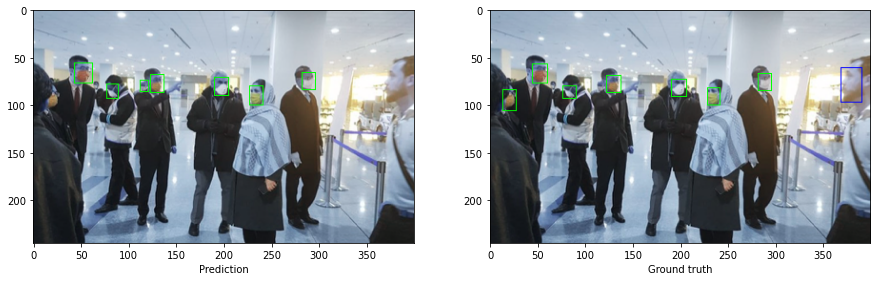

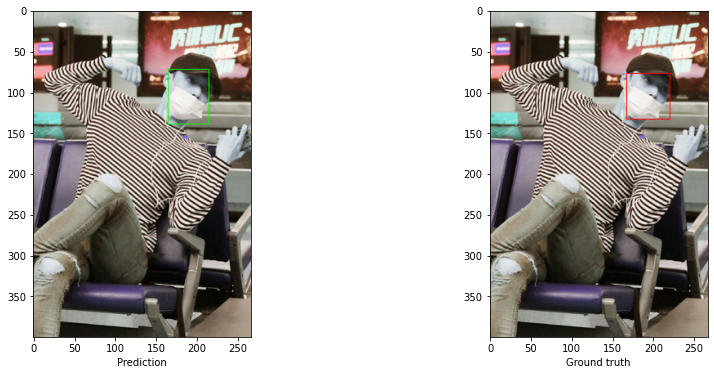

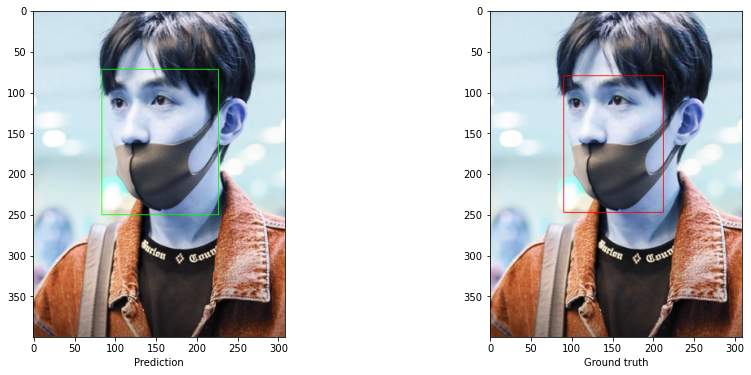

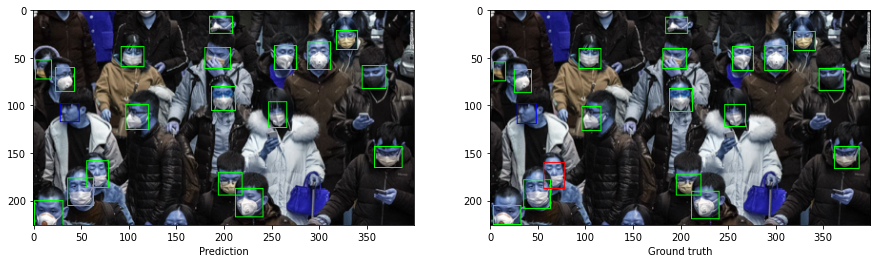

In [447]:
# visualize the incorrect ones
for det in incorrect_detections:
    drawEvaluation(det["prediction"].image, det["annotation"].boxes, det["annotation"].labels,
                   det["prediction"].boxes, det["prediction"].labels)